In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight') # estilo dos gráficos

import warnings # retirar avisos
warnings.filterwarnings('ignore')

In [2]:
path = "../data/daily_load.csv"
df_load = pd.read_csv(path, parse_dates = ["date"])
df_load_sul = df_load[df_load["id_reg"] == "S"]

df_load_sul["load_mwmed"].interpolate(inplace = True)

df_load_sul = df_load_sul[["date", "load_mwmed"]].set_index("date")
df_load_sul.head(5)

,load_mwmed
date,
2000-01-01,4800.650000
2000-01-02,4899.800000
2000-01-03,6261.554167
2000-01-04,6733.741667
2000-01-05,6961.170833


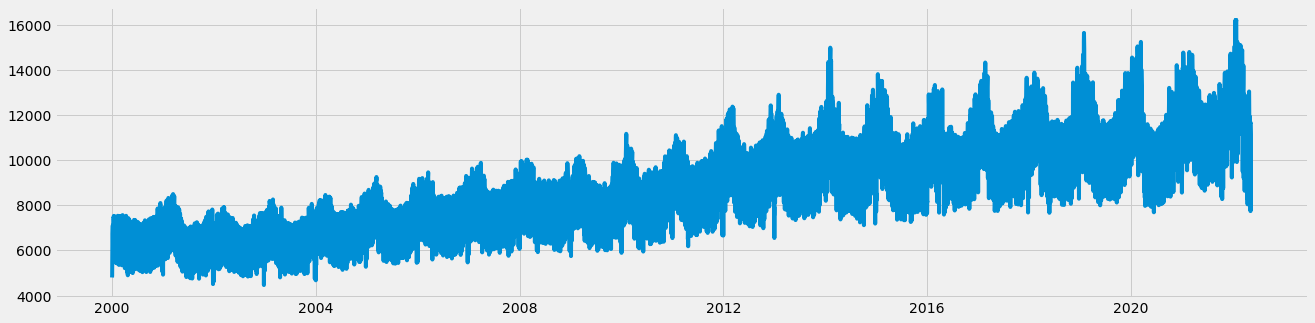

In [3]:
plt.figure(figsize = (20,5))
plt.plot(df_load_sul)
plt.show()

In [4]:
data = df_load_sul.asfreq('d')

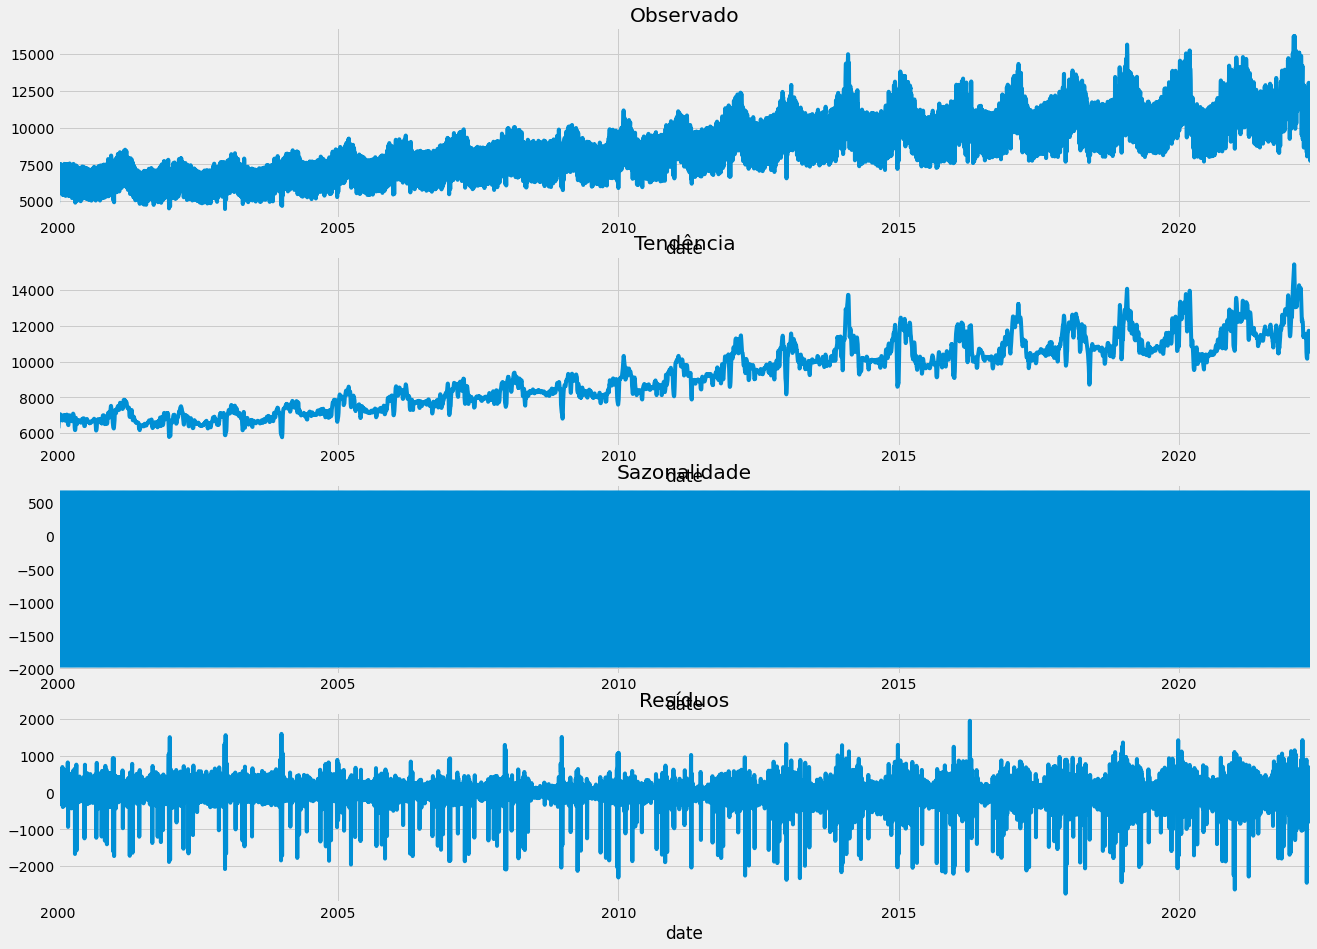

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (20,15))
decompose_data = seasonal_decompose(data, model="additive")

decompose_data.observed.plot(ax = ax1, title = "Observado")
decompose_data.trend.plot(ax = ax2, title = "Tendência")
decompose_data.seasonal.plot(ax = ax3, title = "Sazonalidade")
decompose_data.resid.plot(ax = ax4, title = "Resíduos")

plt.show()

## MODELAGEM

In [5]:
import statsmodels.api as sm

In [6]:
model = sm.tsa.statespace.SARIMAX(data,order=(1, 1, 1),seasonal_order=(1,1,1,7))
results = model.fit()

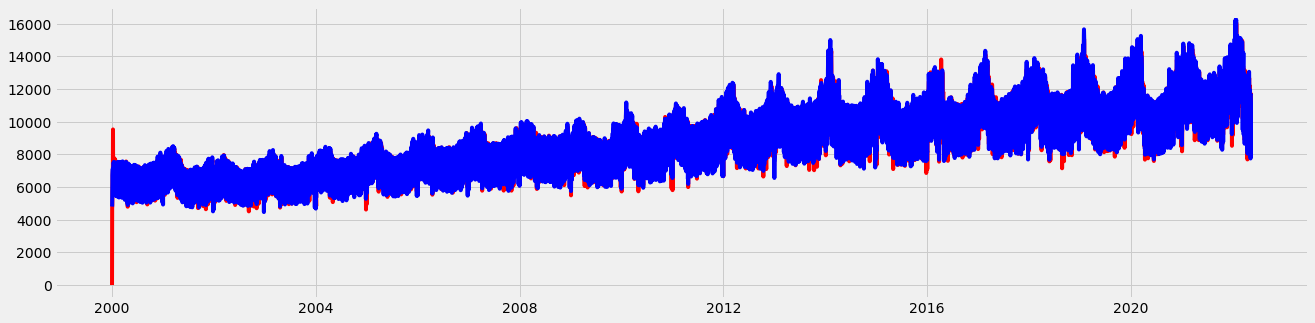

In [7]:
plt.figure(figsize = (20,5))

plt.plot(results.predict(), c = "red")
plt.plot(df_load_sul, c = "blue")

plt.show()

In [8]:
results.forecast(7)

2022-05-12    11595.547051
2022-05-13    11382.235347
2022-05-14     9793.263035
2022-05-15     8491.034261
2022-05-16    11266.631129
2022-05-17    11731.173381
2022-05-18    11826.197401
Freq: D, Name: predicted_mean, dtype: float64

## COM DIVISÃO DE TREINO E TESTE

In [29]:
train, test = df_load_sul.iloc[:-30], df_load_sul.iloc[-30:] 
train.tail(), train.head()

(              load_mwmed
 date                    
 2022-04-07  12512.483583
 2022-04-08  12271.662917
 2022-04-09  10395.100000
 2022-04-10   9137.307083
 2022-04-11  11983.965833,
              load_mwmed
 date                   
 2000-01-01  4800.650000
 2000-01-02  4899.800000
 2000-01-03  6261.554167
 2000-01-04  6733.741667
 2000-01-05  6961.170833)

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

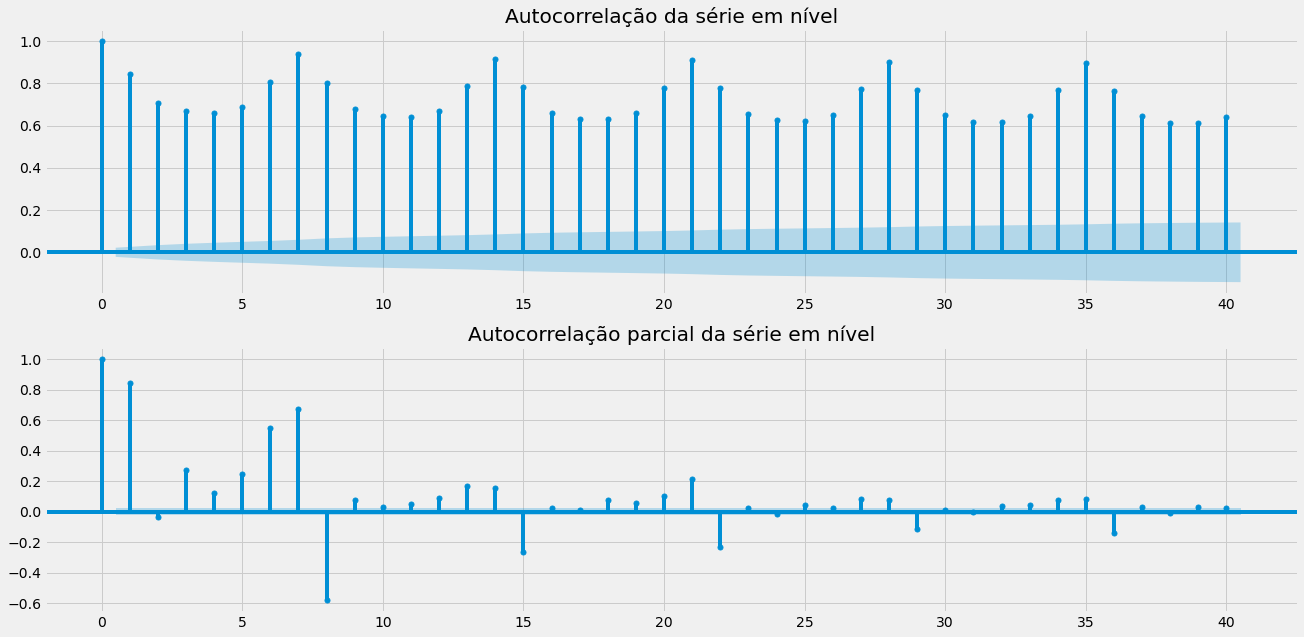

In [22]:
N, M = 20, 10
fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(train["load_mwmed"], title = "Autocorrelação da série em nível", ax = ax1)
plot_pacf(train["load_mwmed"], title = "Autocorrelação parcial da série em nível", ax = ax2)
plt.show()

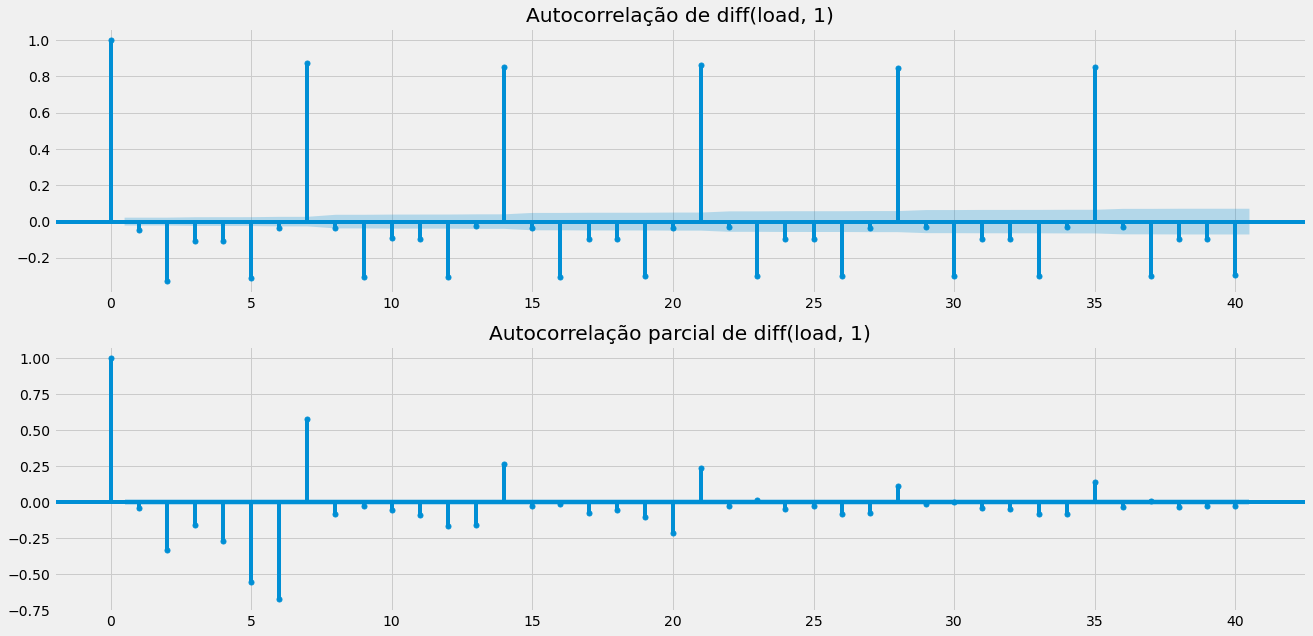

In [23]:
df_load_sul_diff1 = train["load_mwmed"].diff().dropna()

N, M = 20, 10
fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul_diff1, title = "Autocorrelação de diff(load, 1)", ax = ax1)
plot_pacf(df_load_sul_diff1, title = "Autocorrelação parcial de diff(load, 1)", ax = ax2)
plt.show()

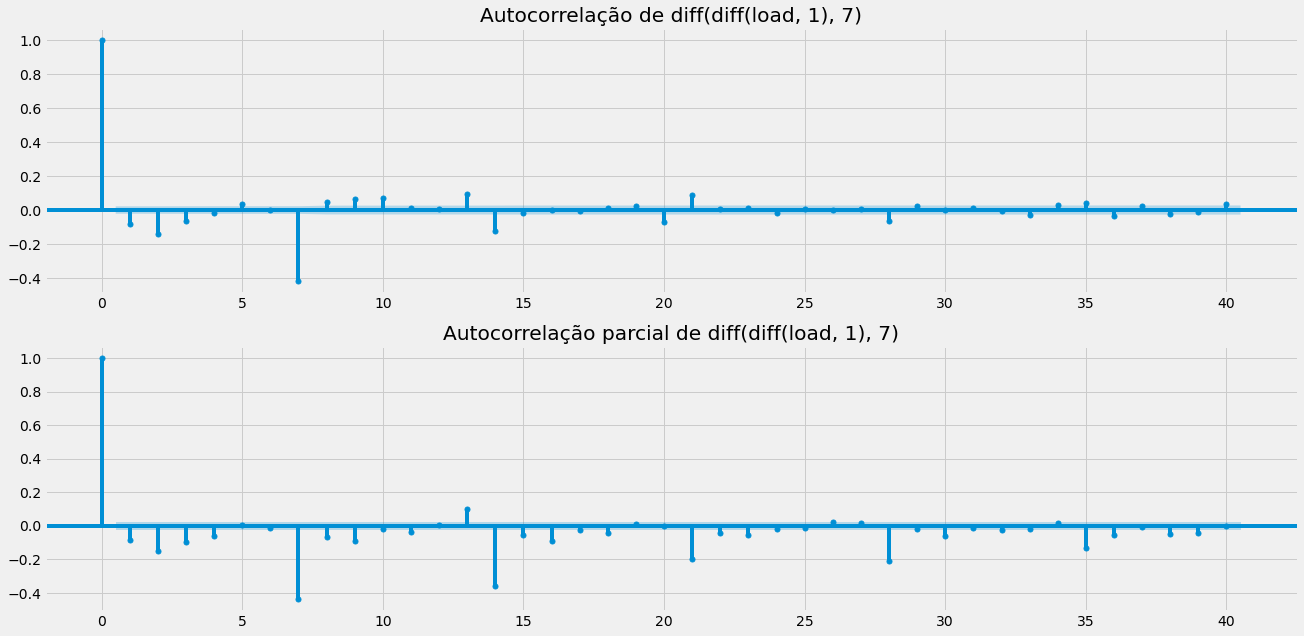

In [24]:
df_load_sul_diff1_diff7 = df_load_sul_diff1.diff(7).dropna()

N, M = 20, 10
fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul_diff1_diff7, title = "Autocorrelação de diff(diff(load, 1), 7)", ax = ax1)
plot_pacf(df_load_sul_diff1_diff7, title = "Autocorrelação parcial de diff(diff(load, 1), 7)", ax = ax2)
plt.show()

In [30]:
# MODELOS

model1 = sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,7))
results1 = model1.fit()

model2 = sm.tsa.statespace.SARIMAX(train,order=(4, 1, 5),seasonal_order=(1,1,1,7))
results2 = model2.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associa

In [31]:
fc1 = results1.forecast(30)
fc1.index = test.index

fc2 = results2.forecast(30)
fc2.index = test.index

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


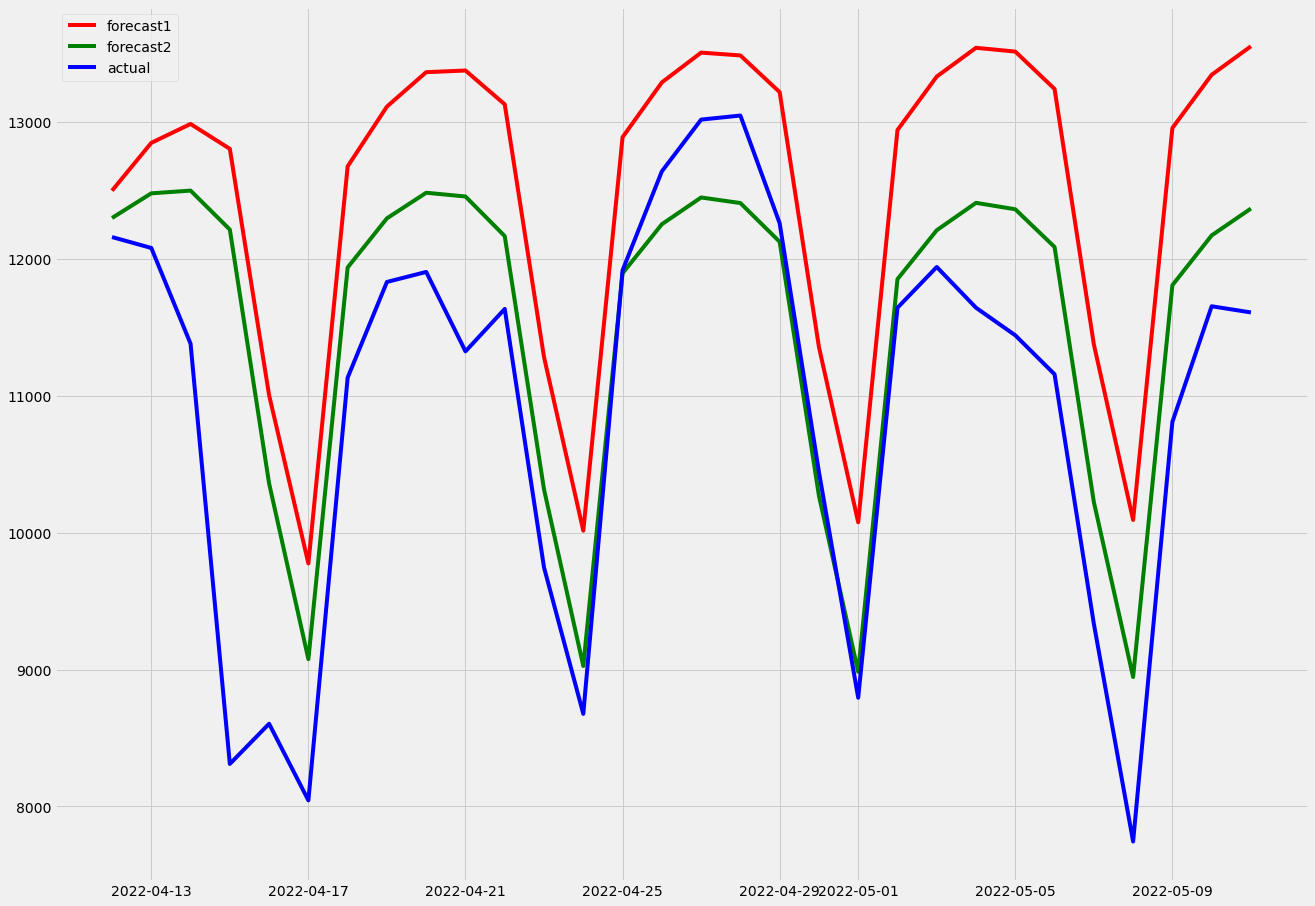

In [34]:
plt.figure(figsize = (20, 15))

plt.plot(fc1, c = "red", label = "forecast1")
plt.plot(fc2, c = "green", label = "forecast2")
plt.plot(test, c = "blue", label = "actual")

plt.legend()

plt.show()

In [44]:
forecast1_errors = [(test.iloc[i][0] - fc1.iloc[i])**2 for i in range(len(test))]
forecast2_errors = [(test.iloc[i][0] - fc2.iloc[i])**2 for i in range(len(test))]
print("Erros quadráticos forecast1:", round(sum(forecast1_errors), 2), " AIC:", round(results1.aic, 2), " BIC:", round(results1.bic, 2))
print("Erros quadráticos forecast2:", round(sum(forecast2_errors), 2), " AIC:", round(results2.aic, 2), " BIC:", round(results2.bic, 2))

Erros quadráticos forecast1: 91014589.44  AIC: 121972.12  BIC: 122007.14
Erros quadráticos forecast2: 31495775.14  AIC: 122688.16  BIC: 122772.2


In [38]:
# MÉTRICAS
from sklearn.metrics import mean_absolute_error
mae1 = mean_absolute_error(test, fc1)
mae2 = mean_absolute_error(test, fc2)

from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(test, fc1)
mse2 = mean_squared_error(test, fc2)

from sklearn.metrics import mean_squared_error
from math import sqrt
mse1 = mean_squared_error(test, fc1)
rmse1 = sqrt(mse1)
mse2 = mean_squared_error(test, fc2)
rmse2 = sqrt(mse2)

def sMAPE(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()

smape1 = sMAPE(test.values, fc1.values)
smape2 = sMAPE(test.values, fc2.values)


## GRID SEARCH

In [27]:
p = [i for i in range(0,5)]
d = 1
q = [i for i in range(0,6)]

In [144]:
# armas = [0, 1, 2, 3, 4, 5]
# ds = [0, 1, 2]

# orders = []
# for p in sarmas:
#     for d in ds:
#         for q in sarmas:
#             for P in sarmas:
#                 for D in ds:
#                     for Q in sarmas:
#                         l_orders = [p, d, q, P, D, Q]
#                         orders.append(l_orders)

In [ ]:
models_performance = []
for p,d,q,P,D,Q in orders:
    model = sm.tsa.statespace.SARIMAX(train,order=(p, d, q),seasonal_order=(P,D,Q,7))
    results = model.fit()
    fc = results.forecast(30)
    fc.index = test.index
    forecast_errors = [test.iloc[i][0] - fc.iloc[i] for i in range(len(test))]
    mae = mean_absolute_error(test, fc)
    mse = mean_squared_error(test, fc)
    rmse = sqrt(mse)
    smape = sMAPE(test.values, fc.values)
    m_aic = results.aic
    m_aicc = results.aicc
    m_bic = results.bic
    name = '_'.join([str(p),str(d),str(q),str(P),str(D),str(Q)])
    new_line = {
                 "model": name,
                 "errors": forecast_errors,
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "smape": smape,
                 "m_aic": m_aic,
                 "m_aicc": m_aicc,
                 "m_bic": m_bic
                 }
    models_performance.append(new_line)
    print("Done:", new_line)


In [148]:
# df_metrics = pd.DataFrame(models_performance)
# df_metrics.to_csv("sarima_est.csv")